# Fully discretized Lippmann

In [250]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [52]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

def get_figure_hd(axes = [0,0,1,1]):
    fig = plt.figure(figsize=(1920/300, 1080/300), dpi=300, facecolor='black', frameon = False)
    ax = plt.Axes(fig, axes, )
    ax.set_axis_off()
    fig.add_axes(ax)
    
    return fig

def get_figure_2hd(axes = [0,0,1,1]):
    fig = plt.figure(figsize=(3840/300, 1080/300), dpi=300, facecolor='black', frameon = False)
    ax = plt.Axes(fig, axes, )
    ax.set_axis_off()
    fig.add_axes(ax)
    
    return fig

def plot_style():
    
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().set_axis_bgcolor('black')
    plt.ylim([-2,2])
    plt.yticks([])
    plt.xticks([])
    
def plot_style_color():
    
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    plt.gca().set_axis_bgcolor('black')
    plt.yticks([])
    plt.xticks([])
    
def save_figure(idx):
    plt.savefig('Frames/' + str(idx).zfill(4) +  '.png', dpi=300, bbox_inches='tight', facecolor=plt.gcf().get_facecolor(), transparent=True)

def plot_mono_plane_wave(A0, space, time, idx):
    
    omega = 2*np.pi
    
    U_r   = A0 * np.exp(-1j*space)
    U_r_t = U_r * np.exp(1j*omega*time)
    
    fig = get_figure_hd()
    
    plt.plot(space, np.real(U_r_t), c='#55D7FF', lw=6)
    plot_style()

In [314]:
import scipy as sp
from scipy.interpolate import interp1d
from skimage.color import rgb2xyz, xyz2rgb
import matplotlib.pyplot as plt


def read_cie_data(wavelengths):
    
    cie_data = np.genfromtxt('cie_cmf.txt', delimiter='	')
    wavelengths_cie = cie_data[:,0]*1E-9     
    cmf_cie = cie_data[:,1:4]
        
    cmf_cie_interp_x = interp1d(wavelengths_cie, cmf_cie[:,0], kind='cubic', bounds_error=False, fill_value=0.0)(wavelengths)     
    cmf_cie_interp_y = interp1d(wavelengths_cie, cmf_cie[:,1], kind='cubic', bounds_error=False, fill_value=0.0)(wavelengths)
    cmf_cie_interp_z = interp1d(wavelengths_cie, cmf_cie[:,2], kind='cubic', bounds_error=False, fill_value=0.0)(wavelengths)      
  
    return cmf_cie_interp_x, cmf_cie_interp_y, cmf_cie_interp_z

def from_spectrum_to_xyz(wavelengths, spectral_colors, normalize=True):
    
    c = 299792458    
    
    cmf_cie_x, cmf_cie_y, cmf_cie_z = read_cie_data(wavelengths=wavelengths)
    nu = c/wavelengths
        
    X = np.trapz(y=spectral_colors*cmf_cie_x, x=nu, axis=spectral_colors.ndim-1)
    Y = np.trapz(y=spectral_colors*cmf_cie_y, x=nu, axis=spectral_colors.ndim-1)    
    Z = np.trapz(y=spectral_colors*cmf_cie_z, x=nu, axis=spectral_colors.ndim-1)  
    
    #'normalize'
    if normalize:
        normalization_cste = np.max(Y)
        X = X/normalization_cste
        Y = Y/normalization_cste
        Z = Z/normalization_cste
        
    return np.stack([X,Y,Z], axis=-1)
    
def from_xyz_to_rgb(xyz_colors, normalize=True):
    
    rgb_colors = xyz2rgb(xyz_colors)
    
    if normalize:
        return rgb_colors/np.max(rgb_colors)
    else:
        return rgb_colors
    
def from_rgb_to_xyz(rgb_colors, normalize=True):
    
    xyz_colors = rgb2xyz(rgb_colors)
    
    if normalize:
        return xyz_colors/np.max(xyz_colors)
    else:
        return xyz_colors
    

In [315]:
def plot_spectrum_poly(wavelengths, spectrum, visible=False):
    
    fig = get_figure_hd()
    
    if visible:
        i = np.where( (wavelengths >= 390E-9) & (wavelengths <= 700E-9) )
        wavelengths   = wavelengths[i]
        spectrum = spectrum[i] 
    
    colors = plt.cm.Spectral_r(np.linspace(0, 1, len(wavelengths)))
    cs = [colors[i] for i in range(len(wavelengths))]
    
    plt.plot(wavelengths, spectrum, c='black', alpha=0.3, lw=1, zorder=1)
    plt.scatter(wavelengths, spectrum, color=cs, s=20, zorder=2)    
    
    plot_style_color()

In [741]:
#functions to plot the plates

def plot_intensity_reflected_pulsed_plane_wave(z, wavelengths, spectrum, color, normalization, plot=True):
    
    #true value of wavelengths
    wavelengths = wavelengths*1E-9
    
    c     = 299792458  #speed of light
    
    wave = np.zeros(len(z))

    for i, wavelength in enumerate(wavelengths):
    
        nu    = c/wavelength
        omega = 2*np.pi*nu
        k     = omega/c

        space = k*z
        
        wave += spectrum[i]**4*np.sin(2*pi*nu*z/c)**2

    if plot:
        fig = get_figure_hd()

        plt.plot(z, wave/normalization, c='#55D7FF', lw=6)
        plot_style()
        plt.ylim([-1.1, 1.1])

        save_figure(0)

        plt.close(fig)
        
    return wave/normalization

def plot_plate(wavelengths, spectrum, plate, visible=False):
    
    #plot spectrum
    plot_spectrum_poly(wavelengths, spectrum, visible=visible)
    
    #plot plate
    fig = get_figure_hd()
    plt.imshow(plate, extent=[0, 1, -1.1, 1.1], aspect='auto', origin='upper', zorder=2, cmap='gray', vmin = np.min(plate), vmax = np.max(plate), interpolation='nearest')
    plt.axis('off');
    
    

def plot_plate_mono(mu=450, plate_depth=20, n_freq=1000, n_pixels=1000, n_depth=1000, windowed=False):

    wavelengths = np.linspace(390, 700, n_freq)
    z           = np.linspace(0, plate_depth*390E-9, n_depth)

    spectrum    = zeros(len(wavelengths))
    spectrum[np.argmin(np.abs(wavelengths-mu))] = 1
    intensity = plot_intensity_reflected_pulsed_plane_wave(z, wavelengths, spectrum=spectrum, color=np.argmin(np.abs(wavelengths-mu)), normalization=np.sum(spectrum)/2, plot=False) 
    
    if windowed:
        intensity *= np.cos(np.linspace(0, np.pi/2, n_depth)) 
    
    plate = tile(intensity, [n_pixels, 1])
    
    plot_plate(wavelengths, spectrum, plate)
    
    return plate, intensity, z, spectrum
    
    
def plot_plate_gaussian(mu=450, sigma=30, plate_depth=20, n_freq=1000, n_pixels=1000, n_depth=1000, windowed=False):

    wavelengths = np.linspace(390, 700, n_freq)
    z           = np.linspace(0, plate_depth*390E-9, n_depth)

    spectrum    = exp(-(wavelengths-mu)**2/(2*sigma**2))/sqrt(2*pi*sigma**2)
    intensity = plot_intensity_reflected_pulsed_plane_wave(z, wavelengths, spectrum=spectrum, color=np.argmin(np.abs(wavelengths-mu)), normalization=np.sum(spectrum)/100, plot=False) 

    if windowed:
        intensity *= np.cos(np.linspace(0, np.pi/2, n_depth))
    
    plate = tile(intensity, [n_pixels, 1])
    
    plot_plate(wavelengths, spectrum, plate)
    
    return plate, intensity, z, spectrum

def quantize_plate(intensity, n_pixels=1000):
    
    plate = np.zeros([n_pixels, len(intensity)])
    int_max = np.max(intensity)
    
    for idx, i in enumerate(intensity):
        plate[:, idx] = (np.random.rand(n_pixels) < i/int_max).astype(np.int)
        
    #plot plate
    fig = get_figure_hd()
    plt.imshow(plate, extent=[0, 1, -1.1, 1.1], aspect='auto', origin='upper', zorder=2, cmap='gray', vmin = np.min(plate), vmax = np.max(plate), interpolation='nearest')
    plt.axis('off');
    
    return plate
    
    

In [723]:
np.cos(np.linspace(0,np.pi/2,100))

array([  1.00000000e+00,   9.99874128e-01,   9.99496542e-01,
         9.98867339e-01,   9.97986676e-01,   9.96854776e-01,
         9.95471923e-01,   9.93838464e-01,   9.91954813e-01,
         9.89821442e-01,   9.87438889e-01,   9.84807753e-01,
         9.81928697e-01,   9.78802446e-01,   9.75429787e-01,
         9.71811568e-01,   9.67948701e-01,   9.63842159e-01,
         9.59492974e-01,   9.54902241e-01,   9.50071118e-01,
         9.45000819e-01,   9.39692621e-01,   9.34147860e-01,
         9.28367933e-01,   9.22354294e-01,   9.16108457e-01,
         9.09631995e-01,   9.02926538e-01,   8.95993774e-01,
         8.88835449e-01,   8.81453363e-01,   8.73849377e-01,
         8.66025404e-01,   8.57983413e-01,   8.49725430e-01,
         8.41253533e-01,   8.32569855e-01,   8.23676581e-01,
         8.14575952e-01,   8.05270258e-01,   7.95761841e-01,
         7.86053095e-01,   7.76146464e-01,   7.66044443e-01,
         7.55749574e-01,   7.45264450e-01,   7.34591709e-01,
         7.23734038e-01,

In [702]:
def floyd_steinberg_dithering(plate, plot=False):
    
    quantized_plate = plate/np.max(plate)
        
    for i in range(plate.shape[0]):
        for j in range(plate.shape[1]):
            pixel = quantized_plate[i,j]
            
            quantized_pixel = np.rint(pixel)
            error = pixel-quantized_pixel
            #replace with new pixel
            quantized_plate[i,j] = quantized_pixel
            
            if j+1 < plate.shape[1]:
                quantized_plate[i,j+1] += error*7/16
                
            if i+1 < plate.shape[0] and j-1 < 1:
                quantized_plate[i+1,j-1] += error*3/16 
                
            if i+1 < plate.shape[0]:
                quantized_plate[i+1,j] += error*5/16 
                
            if i+1 < plate.shape[0] and j+1 < plate.shape[1]:
                quantized_plate[i+1,j+1] += error*1/16
                
                
    #plot plate
    fig = get_figure_hd()
    plt.imshow(quantized_plate, extent=[0, 1, -1.1, 1.1], aspect='auto', origin='upper', zorder=2, cmap='gray', interpolation='nearest')
    plt.axis('off');
            
    return quantized_plate

In [759]:
#replay methods

import matplotlib.gridspec as gridspec

def get_spectrum_from_reflectivity(intensity, z, n_freq, plot=False, root=False):
    
    #light attenuation coefficient
    Kd = 1
    
    wavelengths = np.linspace(390, 700, n_freq)*1E-9
    c     = 299792458  #speed of light
    nu    = c/wavelengths
    omega = 2*np.pi*nu
    k     = omega/c
    
    #white light
    L = np.ones(n_freq)
    
    matrix_exponentials = np.exp(-2j*np.outer(k,z))*np.tile(np.exp(-Kd*z), [len(k), 1])   
    integrals = matrix_exponentials @ intensity
    
    if root:
        spectrum = 4*L*np.abs(integrals)
    else:
        spectrum = 4*L*np.abs(integrals)**2
    
    if plot:
        plot_spectrum_poly(wavelengths, spectrum)
    
    return wavelengths, spectrum


def get_spectrums_from_plate(plate, z, n_freq, plot=False, title=''):
    
    spectrums = np.zeros([plate.shape[0], n_freq])
    rgb_colors = np.zeros([plate.shape[0], 1, 3])
    
    for i in range(plate.shape[0]):
        
        reflectivity = plate[i,:]
        
        w, s = get_spectrum_from_reflectivity(reflectivity, z, n_freq=n_freq, plot=False)
        spectrums[i,:] = s

        xyz = from_spectrum_to_xyz(w, s)
        rgb = from_xyz_to_rgb(xyz.reshape([1,1,3]))
        rgb_colors[i, 0, :] = rgb
        
    if plot:
        plot_spectrums(w, spectrums, rgb_colors, title=title)
    
    return spectrums, rgb_colors
        
def plot_spectrums(w, spectrums, rgb_colors, vmax=None, title=''):
        
    fig = get_figure_hd()
    plt.title(title)

    gs = gridspec.GridSpec(1, 4, width_ratios=[8,1,1,1])
    gs.update(left=0.02, right=0.98, hspace=0.02, wspace=0.02)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])

    if vmax is None:
        vmax = np.max(spectrums)
    
    #plot spectrums
    ax1.imshow(spectrums, extent=[0, 1, -1.1, 1.1], aspect='auto', origin='upper', zorder=2, cmap='gray', vmin=0, vmax=vmax, interpolation='nearest')
    ax1.axis('off');

    #plot rgb
    ax2.imshow(rgb_colors, extent=[0, 1, -1.1, 1.1], aspect='auto', origin='upper', zorder=2, cmap='gray', interpolation='nearest')
    ax2.axis('off');

    #plot average
    ax3.imshow(np.mean(rgb_colors, axis=0).reshape([1,1,3]), extent=[0, 1, -1.1, 1.1], aspect='auto', origin='upper', zorder=2, cmap='gray', interpolation='nearest')
    ax3.axis('off');

    av_spectrum = np.mean(spectrums, axis=0)
    
    av_xyz = from_spectrum_to_xyz(w, av_spectrum)
    av_rgb = from_xyz_to_rgb(av_xyz.reshape([1,1,3]))

    ax4.imshow(av_rgb.reshape([1,1,3]), extent=[0, 1, -1.1, 1.1], aspect='auto', origin='upper', zorder=2, cmap='gray', interpolation='nearest')
    ax4.axis('off');

In [704]:
def generate_plots(mu=600, sigma=30, n_freq=100, n_pixels=100, n_depth=100):
    #generate plate
    gaussian_plate, intensity, z, original_spectrum = plot_plate_gaussian(mu=mu, sigma=sigma, n_freq=n_freq, n_pixels=n_pixels, n_depth=n_depth)
    #gaussian_plate, intensity, z, original_spectrum = plot_plate_mono(mu=mu, n_freq=n_freq, n_pixels=n_pixels, n_depth=n_depth)
    
    #recover spectrum
    w, s = get_spectrum_from_reflectivity(intensity, z, n_freq)
    
    #quantize plate
    quantized_plate = quantize_plate(intensity, n_pixels=n_pixels)
    
    #Floyd-Steinberg dithering
    fs_plate = floyd_steinberg_dithering(gaussian_plate, plot=True)
    #quantized_plate = fs_plate
    
    #recover the spectrums for each pixel
    spectrums, rgb = get_spectrums_from_plate(gaussian_plate, z, n_freq, plot=True, title='Unquantized')

    #recover the quantized spectrums for each pixel
    quantized_spectrums, rgb = get_spectrums_from_plate(quantized_plate, z, n_freq=n_freq, plot=False, title='Quantized')
    
    #compute errors
    errors = np.zeros(n_pixels)
    
    for i in range(n_pixels):
        spec_est = quantized_spectrums[i,:]
        errors[i] = np.linalg.norm(spec_est-original_spectrum)
        
    indices = np.argsort(errors)
        
    sorted_spectrums = quantized_spectrums[indices[::-1], :]
    sorted_rgb       = rgb[indices[::-1], :]
    
    plot_spectrums(w, sorted_spectrums, sorted_rgb, title='Quantized Sorted')
    
    #plot_spectrums(w, np.abs(spectrums-sorted_spectrums/np.max(sorted_spectrums)*np.max(spectrums)), sorted_rgb, title='Absolute difference', vmax=np.max(spectrums))
    
    #select the best spectrum
    best_spectrum  = sorted_spectrums[0,:]
    best_rgb       = sorted_rgb[0,:]
    best_spectrums = np.tile(best_spectrum, [n_pixels, 1])
    best_rgbs       = np.tile(best_rgb, [n_pixels, 1]).reshape([n_pixels, 1, 3])
    
    plot_spectrums(w, best_spectrums, best_rgbs, title='Best repeated')

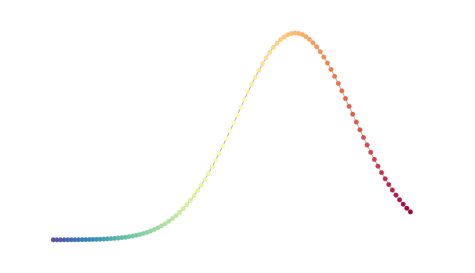

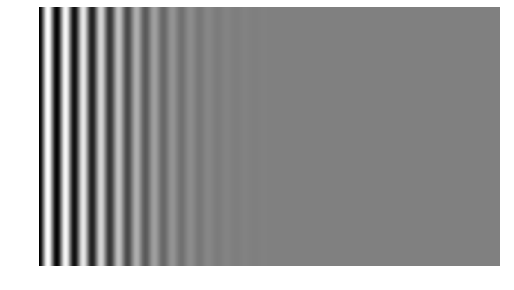

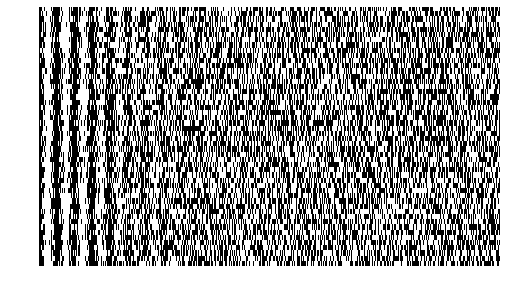

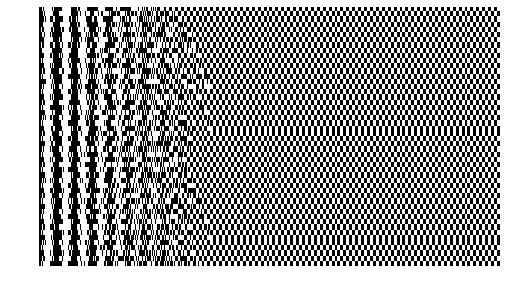

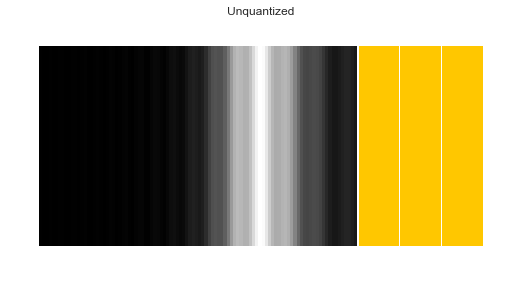

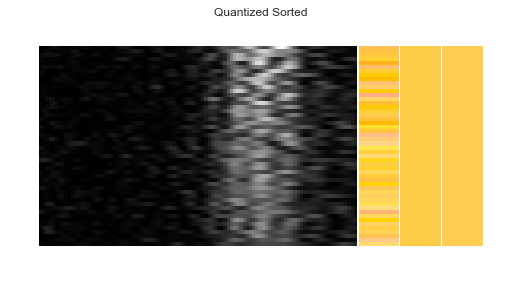

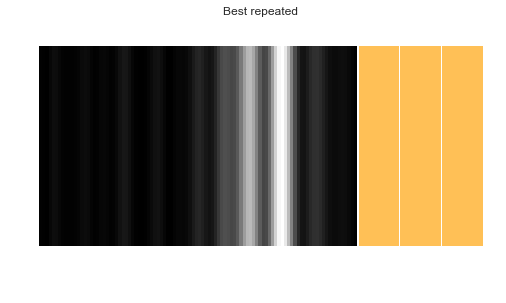

In [705]:
generate_plots(mu=600, sigma=50, n_pixels=50, n_depth=2000)

In [699]:
50*390E-9/20000

9.75e-10

### Blue

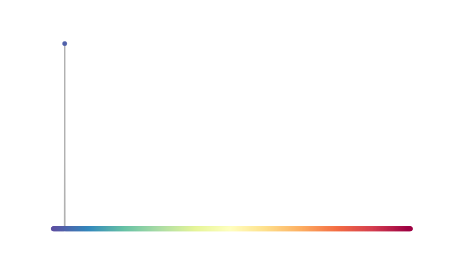

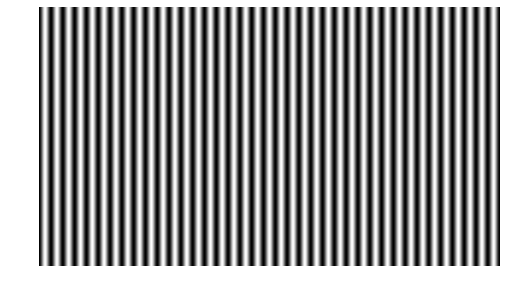

In [706]:
blue, int_blue, z, s = plot_plate_mono(mu=400)

### Red

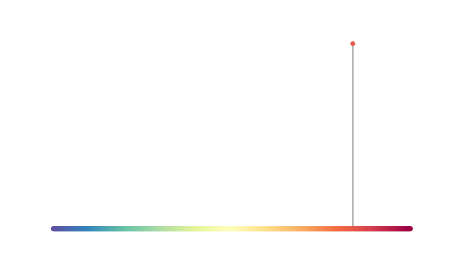

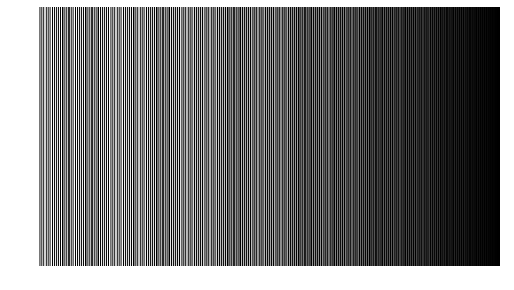

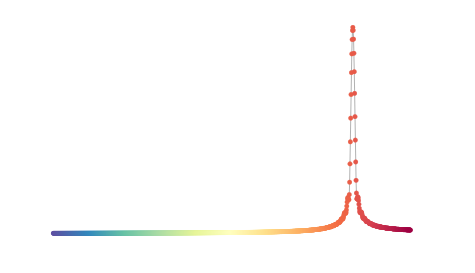

In [760]:
red, int_red, z, s = plot_plate_mono(mu=650, plate_depth=200, windowed=True)
w, s = get_spectrum_from_reflectivity(int_red, z, n_freq=1000, plot=True, root=True)

### Gaussian

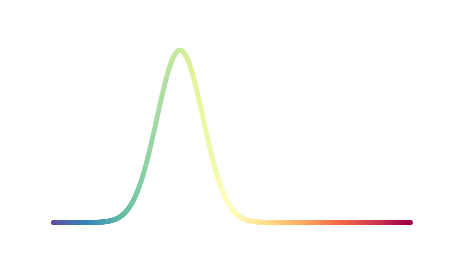

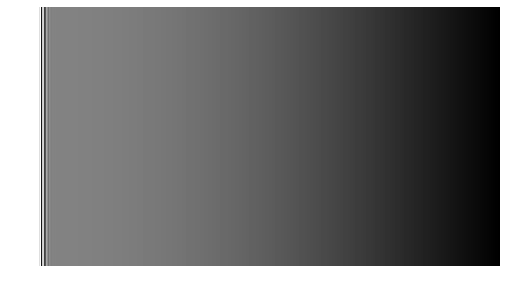

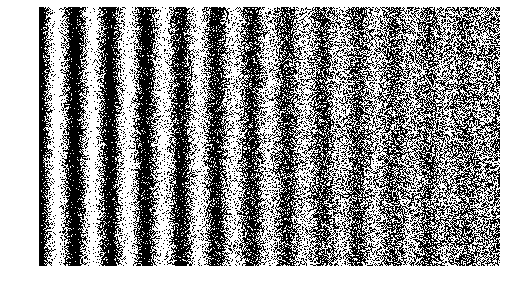

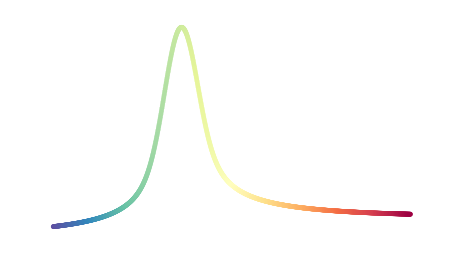

In [772]:
gaussian, int_gaussian, z, s = plot_plate_gaussian(mu=500, sigma=20, plate_depth=500, n_depth=2500, windowed=True)
quantize_plate(intensity, n_pixels=1000)
w, s = get_spectrum_from_reflectivity(int_gaussian, z, n_freq=1000, plot=True, root=True)